# Training the REAL/FAKE classifier

In [7]:
from fastai.core import *
from fastai.vision import *
from efficientnet_pytorch import EfficientNet

In [8]:
path = Path('../data/HardDeepFakes/')
src = ImageList.from_folder(path).split_by_folder(train='train', valid='val')

In [9]:
def get_data(bs,size):
    data = (src.label_from_re('([A-Z]+).png$')
           .transform(get_transforms(max_warp=0, max_zoom=1), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    return data

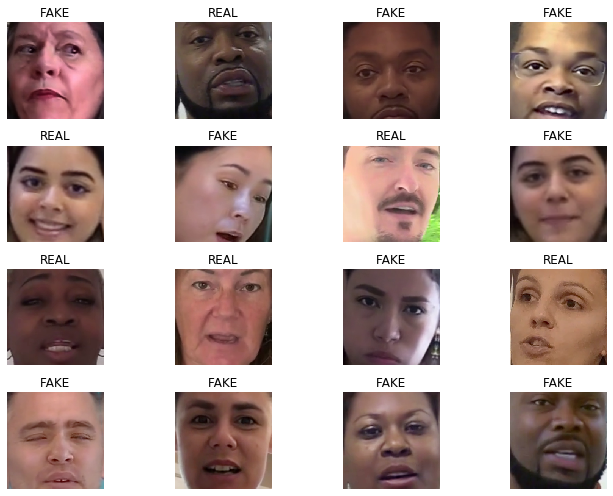

In [10]:
bs, sz = 32, 256
data = get_data(bs, sz)
data.show_batch(rows=4, figsize=(10,7))

## Resnet

In [ ]:
model = models.resnet18(num_classes=2)

In [ ]:
import copy

In [ ]:
fc = copy.deepcopy(model.fc)

In [ ]:
model.fc = nn.Identity()

In [ ]:
state_dict = torch.load('models/resnet_oselect_dfdc.pth')
model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [ ]:
model.fc = fc

In [ ]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [ ]:
learn = Learner(data, model, path='./', metrics=[accuracy])

In [ ]:
learn.lr_find(start_lr=1e-11, end_lr=1e-7)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


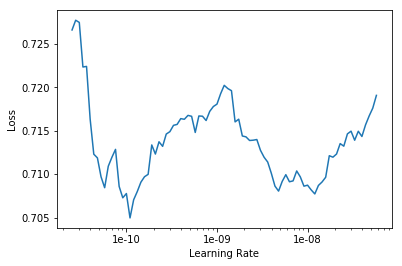

In [ ]:
learn.recorder.plot(skip_end=5)

In [ ]:
learn.fit_one_cycle(cyc_len=5, max_lr=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.711658,0.714238,0.500000,00:43
1,0.710710,0.706583,0.522500,00:41
2,0.703991,0.704125,0.492500,00:41
3,0.703532,0.702864,0.472500,00:43
4,0.700790,0.702296,0.485000,00:44


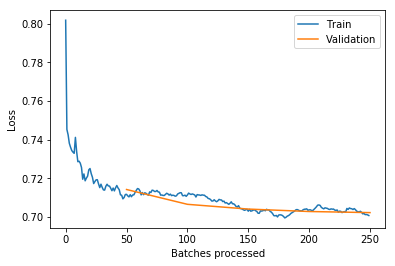

In [ ]:
learn.recorder.plot_losses()

## EfficientNetB0

### Transfer from Imagenet

In [45]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=data.train_dl.c)


Loaded pretrained weights for efficientnet-b0


In [46]:
learn = Learner(data, model, metrics=[accuracy])

In [ ]:
#fm = flatten_model(model)
#learn.layer_groups = [nn.Sequential(*fm[:-3]), nn.Sequential(*fm[-3:])]

In [ ]:
#learn.freeze_to(-1)

In [47]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


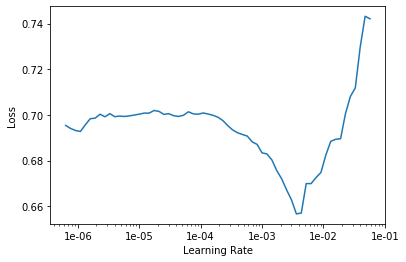

In [49]:
learn.recorder.plot(skip_end=15)

In [50]:
learn.fit_one_cycle(cyc_len=10, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.647150,0.736731,0.520000,00:12
1,0.471439,1.021132,0.600000,00:12
2,0.363030,1.153853,0.640000,00:12
3,0.254090,1.769028,0.642500,00:12
4,0.209522,1.847715,0.665000,00:12
5,0.154738,1.570011,0.632500,00:12
6,0.103999,1.047453,0.665000,00:12
7,0.058224,1.544915,0.682500,00:12
8,0.039093,1.435551,0.682500,00:12
9,0.022698,1.400750,0.685000,00:12


In [51]:
learn.save('effnetb0_classifier_ftimagenet')

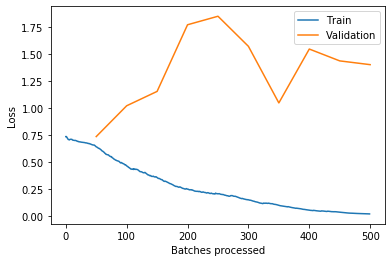

In [52]:
learn.recorder.plot_losses()

### Transfer from Online Selection

In [28]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=data.train_dl.c)


Loaded pretrained weights for efficientnet-b0


In [29]:
import copy

In [30]:
swish0 = copy.deepcopy(model._swish)
fc0 = copy.deepcopy(model._fc)
dropout0 = copy.deepcopy(model._dropout)

In [31]:
model._swish = nn.Identity()
model._fc = nn.Identity()
model._dropout = nn.Identity()

In [32]:
state_dict = torch.load('models/effnetb0_oselect.pth')

In [33]:
model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [34]:
model._swish = swish0
model._fc = fc0
model._dropout = dropout0

In [35]:
learn = Learner(data, model, metrics=[accuracy])

In [36]:
#fm = flatten_model(model)
#learn.layer_groups = [nn.Sequential(*fm[:-3]), nn.Sequential(*fm[-3:])]

In [37]:
#learn.freeze_to(-1)

In [39]:
learn.lr_find(start_lr=1e-8, )

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


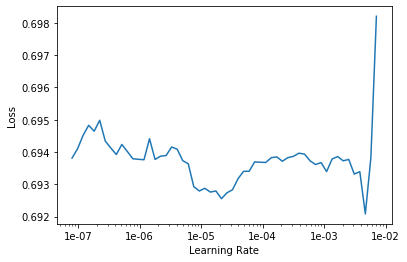

In [40]:
learn.recorder.plot(skip_end=20)

In [44]:
learn.fit_one_cycle(cyc_len=5, max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,2.204687,118739292930441216.000000,0.500000,00:12
1,1.503928,36138.515625,0.490000,00:12
2,1.009963,1.064997,0.500000,00:12
3,0.816718,0.703955,0.500000,00:12
4,0.739513,0.693102,0.487500,00:12


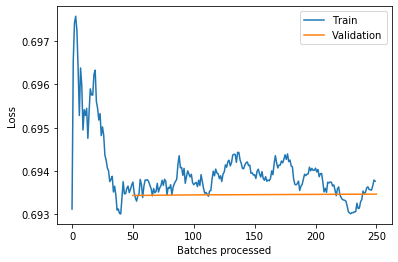

In [43]:
learn.recorder.plot_losses()

In [ ]:
learn.save('effnetb0_classifier_fromoselect')

# -fin